<a href="https://colab.research.google.com/github/lucis-e/BigData_PneumoniaImageIdentification/blob/main/MBC_BigDataFinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pneumonia identification from Chest X-Ray images

    Joaquin Algorta Bove, Miguel La Iglesia Mirones, Laura Masa Martínez and Lucía Muñoz Gil
    Big Data Engineering Final Project, MSc in Computational Biology
    January 2024

**Context:**

http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5

Figure S6.
The normal chest X-ray (left panel) depicts clear lungs without any areas of abnormal opacification in the image. Bacterial pneumonia (middle) typically exhibits a focal lobar consolidation, in this case in the right upper lobe (white arrows), whereas viral pneumonia (right) manifests with a more diffuse ‘‘interstitial’’ pattern in both lungs.

**Content**

The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

## 0. Install and load the required libraries
---

In [ ]:
!pip install pyspark==3.1.2

In [ ]:
# Install latest pre-release version of bigdl-dllib with spark3
# Find the latest bigdl-dllib with spark3 from https://sourceforge.net/projects/analytics-zoo/files/dllib-py-spark3/ and intall it
!pip install https://sourceforge.net/projects/analytics-zoo/files/dllib-py-spark3/bigdl_dllib_spark3-0.14.0b20211107-py3-none-manylinux1_x86_64.whl

exit() # restart the runtime to refresh installed pkg

  Using cached https://sourceforge.net/projects/analytics-zoo/files/dllib-py-spark3/bigdl_dllib_spark3-0.14.0b20211107-py3-none-manylinux1_x86_64.whl (93.9 MB)


In [ ]:
!pip install kaggle

In [ ]:
!pip install lungs-finder

In [ ]:
# Download and load the data
import os
from google.colab import drive, files
from kaggle.api.kaggle_api_extended import KaggleApi  # to retrieve the data for the assignment

# Data management and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

# Spark
from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, MulticlassMetrics
from pyspark.sql.types import StructType, StructField, DoubleType, ArrayType
from pyspark.sql.window import Window

# BigDL - DLlib
from bigdl.dllib.nncontext import *
from bigdl.dllib.keras.layers import *
from bigdl.dllib.keras.models import *
from bigdl.dllib.keras.models import Sequential
from bigdl.dllib.nnframes import *
from bigdl.dllib.nn.criterion import *

# Image visualization
import lungs_finder as lf   # identify the lungs in the image


Prepending /usr/local/lib/python3.10/dist-packages/bigdl/share/dllib/conf/spark-bigdl.conf to sys.path


## 1. Functions employed for this project
---


In [ ]:
def create_image_dataframe(base_path, kind, flag):
  '''
  This function would create a dataset given the path of a directory containing X-ray chest images.
  Each row would represent the information of each image: the name of the file, the type of dataset
  it belongs to (train, test or validation) and if it belongs to a healthy patient or to a patient
  with pneumonia.

  :base_path string: general location where the entire dataset downloaded from kaggle is located
  :kind string: type of data set either train, test or val that includes an specific image
  :flag numerical: either 0 for images of normal patients or 1 for images of individuals with pneumonia
  '''
  image_files = os.listdir(base_path) # get the names of the images contained in the dataset
  aux = pd.DataFrame(image_files)
  aux.columns = ["image_name"]   # name of the image file
  aux["full_path"] = base_path + os.path.sep + aux.image_name # full path of the dataset
  aux["kind"] = kind  # train, test or validation
  aux["flag"] = flag  # normal or pneumonia

  return aux



def calculate_pixel_counts(image_path):
  '''
  This function will calculate the number of pixels in height and width for an image
  given the path where it is saved. Using the imread function from cv2 it would load
  the images from the specified path received as input. Then, height and width dimensions
  would be extracted employing the method .shape.

  :image_path string: the path where the image is located
  '''
  img = cv2.imread(str(image_path)) # load the image located at the given path
  height, width, _ = img.shape  # dimensions in number of pixels

  return height, width



def process_data(img_path, IMAGE_RESOLUTION, BORDER):
    """
    This function process an image adjusting the resolution to a desired number
    "IMAGE_RESOLUTION", identifying where the lungs are and elimination the a fixed number
    of pixels from the borders (BORDER)

    :image_path string: the path where the image is located
    :IMAGE_RESOLUTION array: the desired resolution to normalize all images
    :BORDER integer: fixed number of pixels to cut off the image's border
    """
    try:
        img = cv2.imread(img_path)  # read the image located at the specified path

        # Process the image
        img = cv2.resize(img, IMAGE_RESOLUTION[:2]) # resize to the desired resolution
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # set to grey scale
        img = lf.get_lungs(img, padding=0)  # identify the lungs
        img = img / 255.0   # scaling in the 0 to 1 range
        img = cv2.resize(img, IMAGE_RESOLUTION[:2]) # resize
        img = np.reshape(img, IMAGE_RESOLUTION) # reshape --> QUE?

        return img
    except:
        img = cv2.imread(img_path)  # read the image located at the specified path

        # Process the image
        img = cv2.resize(img, IMAGE_RESOLUTION[:2]) # resize to the desired resolution
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # set to grey scale
        img = img / 255.0   # scaling in the 0 to 1 range
        # Cut the image
        img = img[
            BORDER : IMAGE_RESOLUTION[0] - BORDER, BORDER : IMAGE_RESOLUTION[0] - BORDER
        ]
        img = cv2.resize(img, IMAGE_RESOLUTION[:2]) # resize
        img = np.reshape(img, IMAGE_RESOLUTION) # reshape --> QUE?
        return img



def compose_dataset(df, spark, IMAGE_RESOLUTION, BORDER, batch_size=100):
  '''
  This function takes the dataframe with paths and labels, apply the images precessing
  and transform the pixel matrix to a vector. After that, it returns a spark dataframe with the
  flatenned vector (images column) and the label (class column) of each image.

  :df Dataframe: dataframe containing all the image's information
  :spark SparkSession: Spark Session
  :IMAGE_RESOLUTION array: the desired resolution to normalize all images
  :BORDER integer: fixed number of pixels to cut off the image's border
  :batch_size integer: size of the batch of instances to be processed

  '''
  # Add a continuous row number to the DataFrame
  window_spec = Window.orderBy("full_path")  # Change the orderBy column accordingly
  df_with_row_num = df.withColumn("row_num", F.row_number().over(window_spec))

  initial_schema = StructType([ # schema for the new DataFrame
      StructField("images", ArrayType(DoubleType()), True),
      StructField("class", DoubleType(), True)
  ])

  df_result = spark.createDataFrame(spark.sparkContext.emptyRDD(), schema=initial_schema)   # Empty DataFrame with the initial schema

  total_rows = df.count()
  processed_rows = 0

  while processed_rows < total_rows:
      batch_df = df_with_row_num.filter((col("row_num") >= processed_rows + 1) & (col("row_num") <= processed_rows + batch_size)) # Filter based on the continuous row number

      data_tuples = []
      for row in batch_df.collect():
          full_path = row.full_path
          flag = row["flag"]

          processed_img = process_data(full_path, IMAGE_RESOLUTION, BORDER) # image processing
          dense_vector = processed_img.flatten().tolist()  # convert processed image to Dense Vector
          data_tuples.append((dense_vector, float(flag)))  # append at the end of the list of tuples

      batch_result_df = spark.createDataFrame(data_tuples, schema=initial_schema) # preprocessed batch of images is appended to the dataframe (initially empty)
      df_result = df_result.union(batch_result_df)

      processed_rows += batch_size

  return df_result

## 2. Download the image dataset from Kaggle
---

First, lets set the necessary parameters to use the Kaggle's beta API to download the dataset of study:
- Connect to Google Drive
- Upload the kaggle.json Token (previously downloaded from [kaggle.com](https://www.kaggle.com/) after registration) into Google Drive.

In [ ]:
# Connect Colab Notebook to Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# For uploading the kaggle.json into Google Drive in case it has not been done yet
uploaded = files.upload() # Select the downloaded kaggle.json file to upload into Google Drive

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory


In [ ]:
# Set the os environment where the kaggle.json is saved: in Drive directory, under subdirectory "kaggle"
os.environ["KAGGLE_CONFIG_DIR"] = "/content/drive/MyDrive/kaggle"

Now, lets employ the Kaggle API to download the data of the study

In [ ]:
# Initialize and prepare the Kaggle API
api = KaggleApi()
api.authenticate()

# Download the desired dataset from kaggle
api.dataset_download_files('paultimothymooney/chest-xray-pneumonia', path = ".")

In [ ]:
# Necessary to unzip the folder which contains the chest-xray-pneumonia.csv file
# If the dataset is already downloaded and unzipped, then there is no need to run this chunk of code
! unzip chest-xray-pneumonia.zip -d /content/drive/MyDrive/Colab_Notebooks

## 3. Exploratory Data Analysis
---

Initialize Spark Session with NNcontext

In [ ]:
sc = init_nncontext(cluster_mode="local") # run in local mode
spark = SparkSession(sc)

Current pyspark location is : /usr/local/lib/python3.10/dist-packages/pyspark/__init__.py
Start to getOrCreate SparkContext
pyspark_submit_args is:  --driver-class-path /usr/local/lib/python3.10/dist-packages/bigdl/share/dllib/lib/bigdl-dllib-spark_3.1.2-0.14.0-SNAPSHOT-jar-with-dependencies.jar pyspark-shell 
Successfully got a SparkContext


Create directory paths to the 3 folders: train, test and validation. Also, paths to subfolders NORMAL or PNEUMONIA


In [ ]:
# This is the direction where we just saved the upzipped dataset
dir_path = "/content/drive/MyDrive/Colab_Notebooks/chest_xray"

# Now create the 6 different paths
path_train_normal = os.path.join(dir_path, "train","NORMAL")
path_train_pneu = os.path.join(dir_path , "train","PNEUMONIA")

path_test_normal = os.path.join(dir_path , "test","NORMAL")
path_test_pneu = os.path.join(dir_path , "test","PNEUMONIA")

path_val_normal = os.path.join(dir_path , "val","NORMAL")
path_val_pneu = os.path.join(dir_path , "val","PNEUMONIA")

Now, lets create a final dataset, which is the combination of all the downloaded datasets (from the paths we just constructed). In this dataset each row represents an image. Also, additional information about the source of each image (from train, test or validation datasets, normal or pneumonia) is included in this dataset.

In [ ]:
# Set the grid with all combinations: train, test or validation vs normal (0) or pneumonia (1)
grid = [
    (path_train_normal, "train", 0),
    (path_train_pneu, "train", 1),
    (path_test_normal, "test", 0),
    (path_test_pneu, "test", 1),
    (path_val_normal, "val", 0),
    (path_val_pneu, "val", 1),
]

# Iteratively construct the datasets with the information about the images in each directory and merge to construct a final dataset to work with
dataset = pd.concat([create_image_dataframe(*path) for path in grid]).reset_index(drop=True)
dataset.to_csv("data_image.csv", index=False) # save the final .CSV file
dataset.head()

,image_name,full_path,kind,flag
0,IM-0512-0001.jpeg,/content/drive/MyDrive/Colab_Notebooks/chest_x...,train,0
1,IM-0523-0001-0002.jpeg,/content/drive/MyDrive/Colab_Notebooks/chest_x...,train,0
2,IM-0523-0001-0003.jpeg,/content/drive/MyDrive/Colab_Notebooks/chest_x...,train,0
3,IM-0514-0001.jpeg,/content/drive/MyDrive/Colab_Notebooks/chest_x...,train,0
4,IM-0506-0001.jpeg,/content/drive/MyDrive/Colab_Notebooks/chest_x...,train,0


**Load the dataframe using Spark**

Create a Spark df to work with the data.

In [ ]:
spark_df = spark.createDataFrame(dataset)
spark_df.show(5)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:331: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


+--------------------+--------------------+-----+----+
|          image_name|           full_path| kind|flag|
+--------------------+--------------------+-----+----+
|   IM-0512-0001.jpeg|/content/drive/My...|train|   0|
|IM-0523-0001-0002...|/content/drive/My...|train|   0|
|IM-0523-0001-0003...|/content/drive/My...|train|   0|
|   IM-0514-0001.jpeg|/content/drive/My...|train|   0|
|   IM-0506-0001.jpeg|/content/drive/My...|train|   0|
+--------------------+--------------------+-----+----+
only showing top 5 rows



In [ ]:
spark_df.columns

['image_name', 'full_path', 'kind', 'flag']

In [ ]:
spark_df.printSchema()

root
 |-- image_name: string (nullable = true)
 |-- full_path: string (nullable = true)
 |-- kind: string (nullable = true)
 |-- flag: long (nullable = true)



The columns of the dataframe we created (and that contains the information about all the chest X-ray images) represent:
- **image_name**: name of the image file.
- **full_path**: path of the directory (dataset of images) containing each of the images in the dataset.
- **kind**: type of source dataset the image belongs to (train, test or validation).
- **flag**: 0 for normal, 1 for pneumonia. This is the label or flag that our ML will be predicting based on the image information.

In [ ]:
# Check for null values
spark_df.select([count(when(isnan(c) | col(c).isNull() | (col(c) == '') | col(c).contains('NULL') | col(c).contains('None'), c)).alias(c) for c in spark_df.columns]).show()

+----------+---------+----+----+
|image_name|full_path|kind|flag|
+----------+---------+----+----+
|         0|        0|   0|   0|
+----------+---------+----+----+



We can see that there are no rows with missing values. This makes sense since we constructed the dataset based on the image information of the dataset we downloaded from Kaggle, but represent a good quality check to not encounter some problems in further steps of the project.

**Basic statistics of the label to be predicted in the complete dataset**

In [ ]:
spark_df.select('flag').describe().toPandas()

,summary,flag
0,count,5856
1,mean,0.7296789617486339
2,stddev,0.4441635546399348
3,min,0
4,max,1


There are 5856 observations (images) in the complete dataset (incuding train, test and validation sets and both normal and pneumonia images). We can see that the mean is around 0.73, which might suggest that pneumonia images might be a bit overrepresented in the complete dataset (since we would expect the mean value to be around 0.50 for a balanced dataset).

We would split the complete dataset into train, test and validation sets, that would be used in the development of our ML model for the prediction of pneumonia.

In [ ]:
train_data = spark_df.filter(spark_df.kind == "train").select("full_path", "flag")
test_data = spark_df.filter(spark_df.kind == "test").select("full_path", "flag")
val_data = spark_df.filter(spark_df.kind == "val").select("full_path", "flag")

print(f"Training Set has: {train_data.count()} images")
print(f"Testing Set has: {test_data.count()} images")
print(f"Validation Set has: {val_data.count()} images")

Training Set has: 5216 images
Testing Set has: 624 images
Validation Set has: 16 images


Now, lets explore these datasets. Let's see how the label or "flag" to be predicted is distributed along these three datasets, to check if we are handling with rather balanced datasets or maybe we should consider performing some techniques to balance our training dataset and reduce the introduction of bias in our predictive model

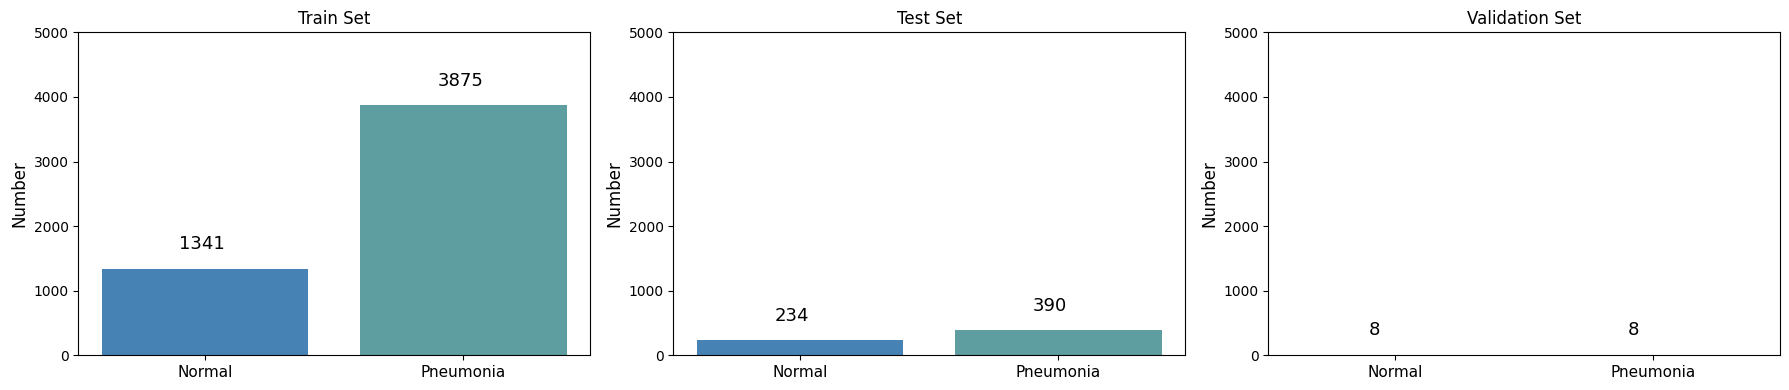

In [ ]:
colors = ['steelblue', 'cadetblue']

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

for i, data in enumerate([train_data, test_data, val_data]):

    flag_counts = data.groupBy('flag').count().collect()  # count number of images per group (normal or pneumonia) and get the result
    # Get the counts:
    categories = [row['flag'] for row in flag_counts] # normal or pneumonia
    counts = [row['count'] for row in flag_counts]  # counts

    bars = axes[i].bar(categories, counts, color=colors)
    axes[i].set_title(['Train Set', 'Test Set', 'Validation Set'][i]) # plot each dataset in the subplots of the figure
    axes[i].set_ylabel("Number", fontsize=12)
    axes[i].set_ylim(0, 5000) # to show a shared y axis
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(['Normal', 'Pneumonia'], fontsize=11)

    for p in bars:  # to print the actual number of observations of each kind
        axes[i].annotate(int(p.get_height()), (p.get_x()+0.30, p.get_height()+300), fontsize=13)

plt.tight_layout()
plt.show()

It is clear that the training set is overrepresented with pneumonia images, while test and validation sets are quite balanced.

Focusing on our training set, we can plot the distribution of its observations:

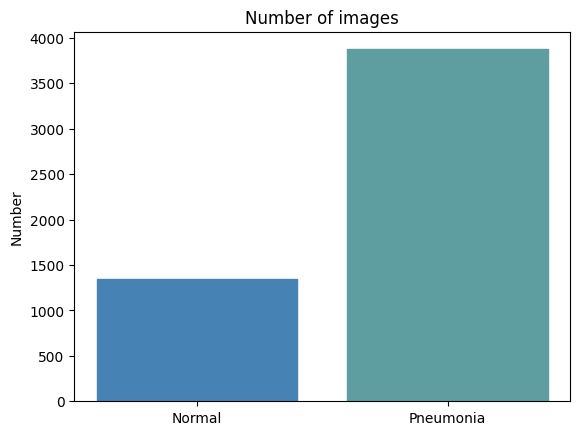

In [ ]:
flag_counts = train_data.groupBy('flag').count().collect()    # only for train data this time

categories = [row['flag'] for row in flag_counts] # normal or pneumonia
counts = [row['count'] for row in flag_counts]  # counts

# Now, lets plot the results
bars = plt.bar(categories, counts)
plt.title('Number of images')
plt.ylabel('Number')
plt.xticks(categories, ['Normal', 'Pneumonia'])

bars[0].set_color('steelblue')
bars[1].set_color('cadetblue')

plt.show()

We can clearly see that the dataset is not balanced at all. There are significantly more pneumonia occurrences than normal ones. We then should consider if this event would lead to overfitting or worse predictive capability of our model due to the high representation of pneumonia images, and maybe cosider create a more balanced dataset to reduce bias.

We can also plot the resolution (height and width of the images) in order to adjust the preprocessing of the images.

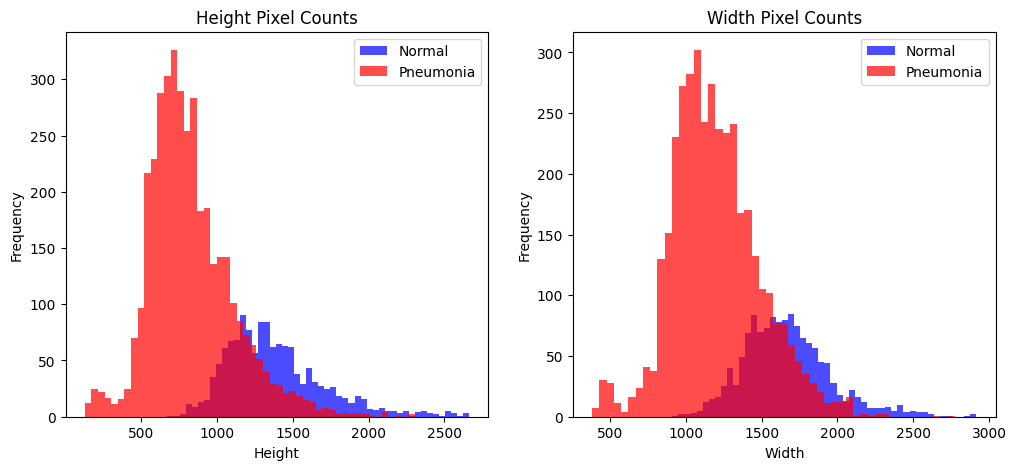

In [ ]:
# Create two datasets, each for either images from healthy normal individuals and other for patients with pneumonia
normal_images = train_data.filter(col('flag') == 0).select("full_path")
pneu_images = train_data.filter(col('flag') == 1).select("full_path")

# Calculate the pixel counts for either normal or pneumonia images
normal_pixel_counts = [calculate_pixel_counts(row['full_path']) for row in normal_images.collect()]
pneumonia_pixel_counts = [calculate_pixel_counts(row['full_path']) for row in pneu_images.collect()]

# Plot histograms
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.hist([item[0] for item in normal_pixel_counts], bins=50, color='blue', alpha=0.7, label='Normal')
ax1.hist([item[0] for item in pneumonia_pixel_counts], bins=50, color='red', alpha=0.7, label='Pneumonia')
ax1.set_title('Height Pixel Counts')
ax1.set_xlabel('Height')
ax1.set_ylabel('Frequency')
ax1.legend()

ax2.hist([item[1] for item in normal_pixel_counts], bins=50, color='blue', alpha=0.7, label='Normal')
ax2.hist([item[1] for item in pneumonia_pixel_counts], bins=50, color='red', alpha=0.7, label='Pneumonia')
ax2.set_title('Width Pixel Counts')
ax2.set_xlabel('Width')
ax2.set_ylabel('Frequency')
ax2.legend()

plt.show()

There is a wide variety of resolutions in our datasets, adjusting it is necessary.

## 4. Preprocessing

---

**4.1 Normalize the size of the images**

Preprocessing is a crucial step in the development of efficient ML models. Processing and transforming of the data should be included, with the development and evaluation of the learning model, in the iterative process of model refinement.

In this case, we consider the images in the dataset should be resized so they all have the same resolution. By performing this we aim to standardize the dataset so all images have the same number of pixels. To do this, we will transform all images to the grey scale and identify the lungs with the lungs_finder package. Then, we will scale the pixel values between zero and one, resizing and reshaping the image to the desired resolution. In our case we choose a resolution of 250x250 and a single channel (grayscale). We also chose to exclude 30 pixels from the borders of the image, for adding simplicity to the model.

In [ ]:
# Set resizing parameters: resolution (number of pixels per dimension) and number of pixels to cut from the image's border
IMAGE_RESOLUTION = (100, 100, 1)
BORDER = 30
print('Image shape: {}'.format(IMAGE_RESOLUTION))


# Divide the datasets into train, test and validation sets
train_set = spark_df.filter(spark_df.kind == "train")[["full_path", "flag"]]
test_set = spark_df.filter(spark_df.kind == "test")[["full_path", "flag"]]
val_set = spark_df.filter(spark_df.kind == "val")[["full_path", "flag"]]


# Preprocess all three datasets
train_set_preprocessed = compose_dataset(train_set, spark,IMAGE_RESOLUTION, BORDER)
test_set_preprocessed = compose_dataset(test_set, spark, IMAGE_RESOLUTION, BORDER)
val_set_preprocessed = compose_dataset(val_set, spark, IMAGE_RESOLUTION, BORDER)

Image shape: (100, 100, 1)


Now, lets visualize some of the images that we are working with

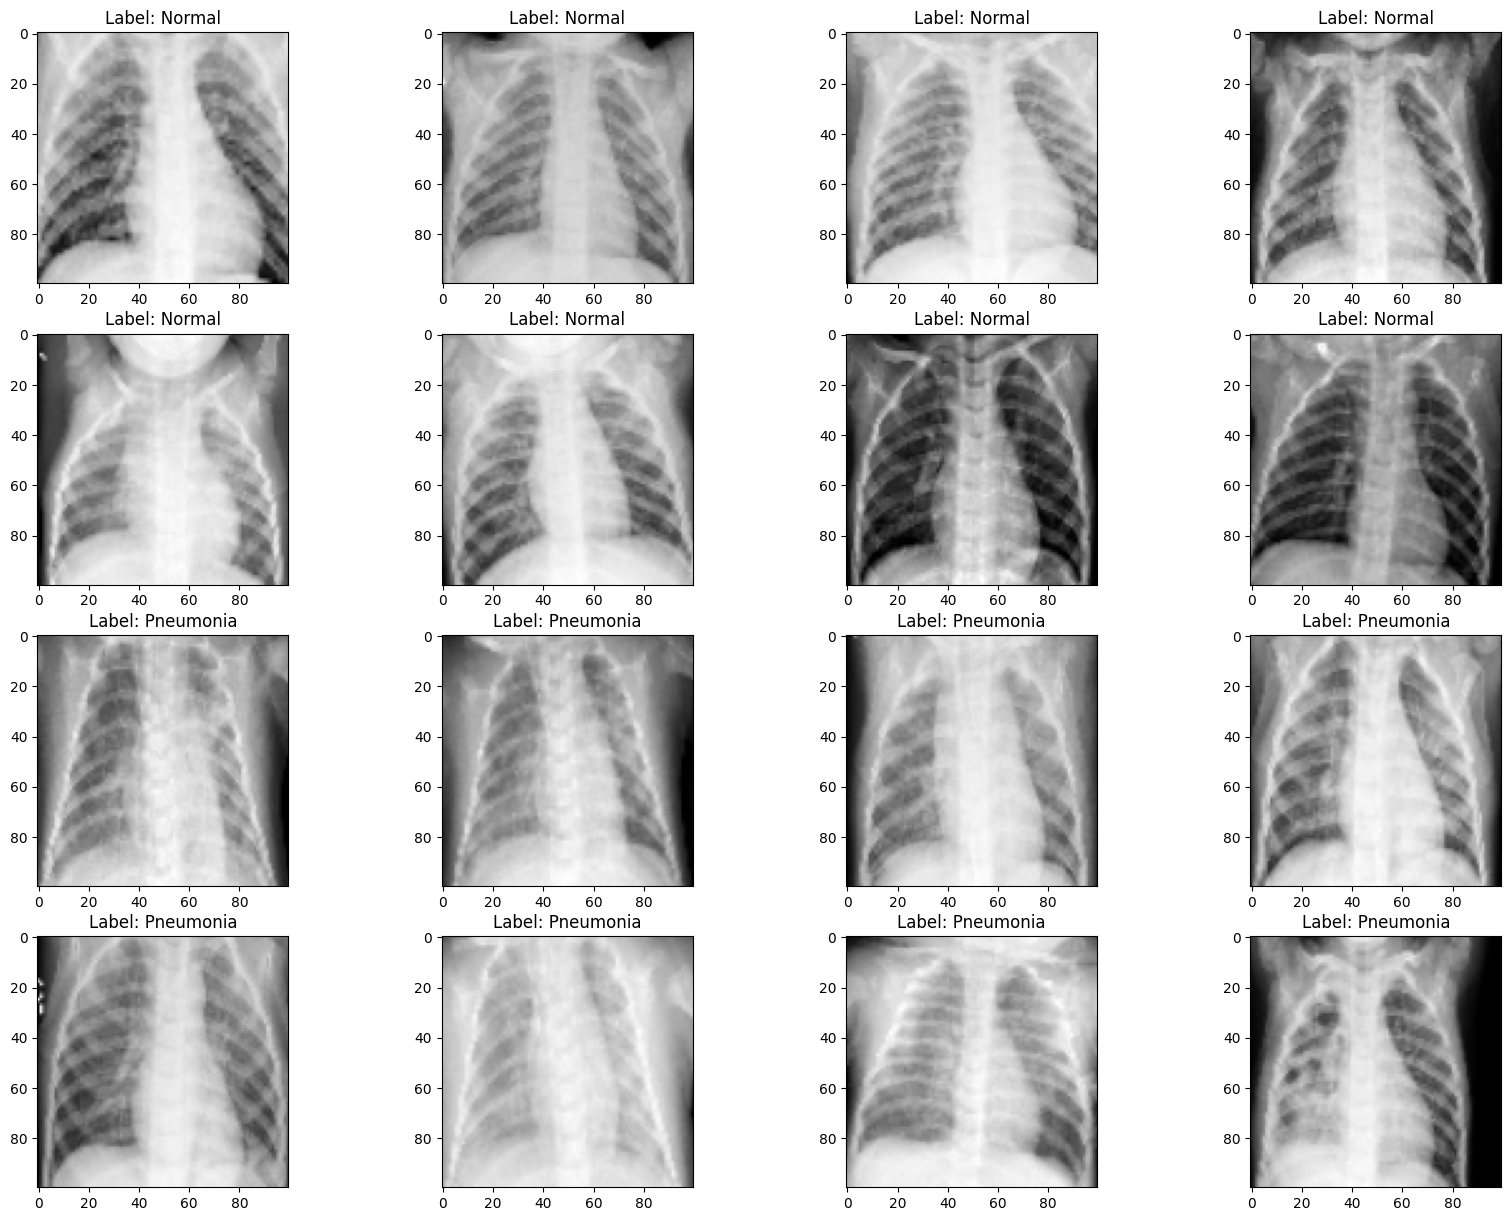

In [ ]:
df_pandas = val_set_preprocessed.toPandas()

X_val = df_pandas['images'].apply(lambda x: np.array(x))
y_val = df_pandas['class']

labels = ["Pneumonia" if y else "Normal" for y in y_val]
plt.figure(figsize=(20, 15))
for i, x in enumerate(X_val):
    plt.subplot(4, 4, i + 1)
    plt.imshow(x.reshape(IMAGE_RESOLUTION), 'gray')
    plt.axis("on")
    plt.title("Label: {}".format(labels[i]))

plt.show()

**4.2 Prepare the data for modeling**

Once we have created the dataframes with the processed images, lets explore this datasets and prepare them for training the model and classification tasks.

Lets do some quality checking so the dimensions of the test set have not changed:

In [ ]:
num_rows = test_set_preprocessed.count()
num_columns = len(test_set_preprocessed.columns)
print(f"Number of Rows: {num_rows}")
print(f"Number of Columns: {num_columns}")

Number of Rows: 624
Number of Columns: 2


Also that there are only two classes or labels: normal or pneumonia.

In [ ]:
distinct_values = test_set_preprocessed.select("class").distinct().rdd.flatMap(lambda x: x).collect()
print(distinct_values)

[0.0, 1.0]


Lets check the schema of our datasets and the lenght of the vector with the image information or pixels (should match the specified resolution).

In [ ]:
train_set_preprocessed.printSchema()

root
 |-- images: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- class: double (nullable = true)



In [ ]:
first_vector = train_set_preprocessed.select("images").first()["images"]
vector_length = len(first_vector)
vector_length

10000

We are going to prepare the dataframe so it only has two columns, one with the information about the images and another with the label or class to be predicted (pneumonia or normal)

In [ ]:
numpy_tovector_udf = udf(lambda x: Vectors.dense(x), VectorUDT())

train_vc = train_set_preprocessed.withColumn("images", numpy_tovector_udf("images"))
test_vc = test_set_preprocessed.withColumn("images", numpy_tovector_udf("images"))
val_vc = val_set_preprocessed.withColumn("images", numpy_tovector_udf("images"))

In [ ]:
train_vc.printSchema()

root
 |-- images: vector (nullable = true)
 |-- class: double (nullable = true)



In [ ]:
train_vc.show(5)

+--------------------+-----+
|              images|class|
+--------------------+-----+
|[0.45882352941176...|  0.0|
|[0.34117647058823...|  0.0|
|[0.34901960784313...|  0.0|
|[0.43529411764705...|  0.0|
|[0.34117647058823...|  0.0|
+--------------------+-----+
only showing top 5 rows



Using Vector Assembler function we will create the "features" and "label" columns for modelling

In [ ]:
vecAssembler = VectorAssembler(inputCols=["images"], outputCol="features")
train_df = vecAssembler.transform(train_vc)
train_final = train_df.withColumn("label", train_df["class"].cast(DoubleType())+lit(1))\
    .select("features", "label")

vecAssembler = VectorAssembler(inputCols=["images"], outputCol="features")
test_df = vecAssembler.transform(test_vc)
test_final = test_df.withColumn("label", test_df["class"].cast(DoubleType())+lit(1))\
    .select("features", "label")

vecAssembler = VectorAssembler(inputCols=["images"], outputCol="features")
val_df = vecAssembler.transform(val_vc)
val_final = val_df.withColumn("label", val_df["class"].cast(DoubleType())+lit(1))\
    .select("features", "label")

train_final.select("label").tail(10)

[Row(label=2.0),
 Row(label=2.0),
 Row(label=2.0),
 Row(label=2.0),
 Row(label=2.0),
 Row(label=2.0),
 Row(label=2.0),
 Row(label=2.0),
 Row(label=2.0),
 Row(label=2.0)]

Please notice that now specific labels have changed as follows:
- 1 for images from normal or healthy patients
- 2 for images from patients with pneumonia

In [ ]:
distinct_values = train_final.select("label").distinct().rdd.flatMap(lambda x: x).collect()
print(distinct_values)

[1.0, 2.0]


## 5. Build the model (Neural Network)
----

Define the structure of the network and the hyperparameters.

In [ ]:
x1 = Input(shape=(10000,))
dense1 = Dense(12, activation='relu')(x1)
dense2 = Dense(8, activation='relu')(dense1)
dense3 = Dense(2)(dense2)
model = Model(x1, dense3)

creating: createZooKerasInput
creating: createZooKerasDense
creating: createZooKerasDense
creating: createZooKerasDense
creating: createZooKerasModel


In [ ]:
classifier = NNClassifier(model, CrossEntropyCriterion(), [10000]) \
    .setOptimMethod(Adam()) \
    .setBatchSize(64) \
    .setMaxEpoch(50)

creating: createCrossEntropyCriterion
creating: createScalarToTensor
creating: createSeqToTensor
creating: createFeatureLabelPreprocessing
creating: createNNClassifier
creating: createAdam


## 6. Train the model

Before training the model, we randomized the order of the training dataset to avoid having all images with label 1 appear first and all images with label 2  later in the dataset. This helps prevent potential biases during training (aditionally if the dataset would have been splited, this would help avoid the potential introduction of biases).

In [ ]:
# Add a new column 'rand_col' with random values
train_final = train_final.withColumn('rand_col', rand())

# Order the DataFrame by 'rand_col' to get a random order
randomized_df = train_final.orderBy('rand_col').drop('rand_col')
randomized_df.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = true)



Training of the model.

In [ ]:
nnmodel = classifier.fit(randomized_df)

creating: createToTuple
creating: createChainedPreprocessing


## 6. Predict and evaluate results
---
Once the model is constructed and trained, it can be evaluated by assesing its performance in the classification of an external set of images. To evaluate its performance, the accuracy of the classification is the standard metric to be employed in classification tasks.

In [ ]:
predictionDF = nnmodel.transform(test_final).cache()  # predict for new, unseen instances (test_set)
predictionDF.sample(False, 0.1).show()

evaluator = MulticlassClassificationEvaluator(  # evaluate the models performance
    labelCol="label", predictionCol="prediction", metricName="accuracy")  # we selected accuracy as the standard evaluation metric in classification tasks
accuracy = evaluator.evaluate(predictionDF)

print("Accuracy = %g " % (accuracy))

+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|[0.23529411764705...|  1.0|       2.0|
|[0.10588235294117...|  1.0|       1.0|
|[0.27843137254901...|  1.0|       2.0|
|[0.19215686274509...|  1.0|       2.0|
|[0.26274509803921...|  1.0|       1.0|
|[0.29803921568627...|  1.0|       1.0|
|[0.16078431372549...|  1.0|       2.0|
|[0.65882352941176...|  1.0|       1.0|
|[0.53333333333333...|  1.0|       1.0|
|[0.14117647058823...|  1.0|       1.0|
|[0.72156862745098...|  1.0|       2.0|
|[0.50588235294117...|  1.0|       1.0|
|[0.42352941176470...|  1.0|       2.0|
|[0.46666666666666...|  1.0|       2.0|
|[0.4,0.3965490196...|  1.0|       2.0|
|[0.52941176470588...|  1.0|       2.0|
|[0.49411764705882...|  1.0|       2.0|
|[0.30588235294117...|  1.0|       2.0|
|[0.50980392156862...|  1.0|       1.0|
|[0.59607843137254...|  1.0|       1.0|
+--------------------+-----+----------+
only showing top 20 rows

Accuracy = 0.7

The model's classification accuracy is of 78%, which tells that the performance of the model is reasonable, but it depends on several factors and further evaluation should be consider.

Appart from accuracy, other evaluation metrics can be employed to assess our models performance, such as precision, recall and F1-score. These other metrics might help get a better idea of the model's performance, specially given a dataset with imbalanced classes which is our case.

Lets estimate this metrics in order to have a better idea of the model's performance. We decided to calculate both the weigthed precision and recall as it provides a better idea of the performance of our model when classifing both pneumonia and normal images.

In [ ]:
# Other metrics can be calculated similarly
precision = evaluator.evaluate(predictionDF, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictionDF, {evaluator.metricName: "weightedRecall"})
f1 = evaluator.evaluate(predictionDF, {evaluator.metricName: "f1"})

# Print additional metrics
print("Precision = {:.2%}".format(precision))
print("Recall = {:.2%}".format(recall))
print("F1 Score = {:.2%}".format(f1))

Precision = 82.50%
Recall = 78.37%
F1 Score = 75.92%


Precision means that out of all the examples predicted as positive by the model, 82.50% were actually positive. Precision is valuable when minimizing false positives is crucial, such as in medical diagnoses which is our case. On the other hand, recall is important when capturing all positive instances is essential, as for example in severe clincal conditions where disease detection is crucial. Finally, with an F1 score of 75.92%, it suggests a reasonable balance between precision and recall.

Overall, this metrics show a reasonable performance of our model. However, given the context of the problem, further development and refinement of the model should be considered in order to reach a more efficient and precise classification model for pneumonia identification.

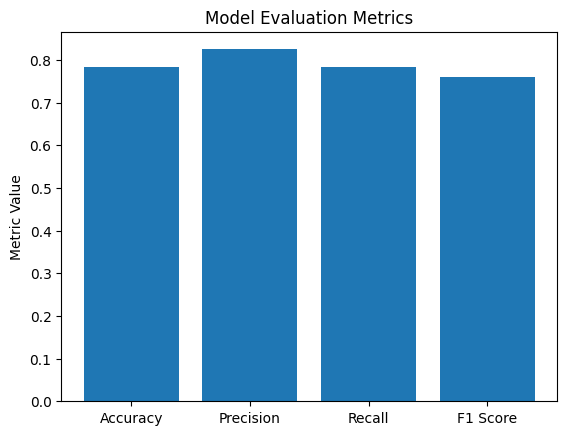

In [ ]:
# We can plot these results for a better visualization and understanding
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy, precision, recall, f1]

plt.bar(metrics, values)
plt.ylabel('Metric Value')
plt.title('Model Evaluation Metrics')
plt.show()


Finally, lets plot the confusion matrix, as it would allow us to better understand if our model tends to fail in the classification of an specific group of instances, which would suggest that the model might be overfitted or biased due to the nature of the training data.

Accuracy: 0.7836538461538461
Confusion Matrix:
[[104. 130.]
 [  5. 385.]]


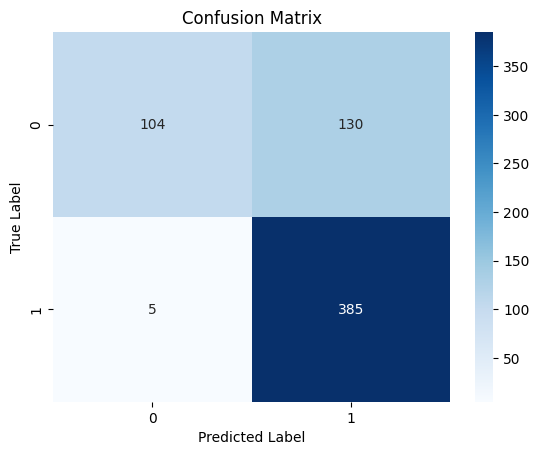

In [ ]:
# Print again the accuracy of the model
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")

accuracy = evaluator.evaluate(predictionDF)
print(f"Accuracy: {accuracy}")

# Create the confusion matrix:
prediction_and_label = predictionDF.select("prediction", "label").rdd # prepare the data: from dataframe RDD for MulticlassMetrics
metrics = MulticlassMetrics(prediction_and_label) # MulticlassMetrics object

conf_matrix_array = metrics.confusionMatrix().toArray() # finally create the confusion matrix

# Plot the confusion matrix
print("Confusion Matrix:")
print(conf_matrix_array)
sns.heatmap(conf_matrix_array, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Finally, as we can see in the confusion matrix, the model is highly efficient predicting those patients with pneumonia: out of 390 chest x-ray images of patients with pneumonia, the model efficiently predicted 385. This is extremely important as it shows that our model is very efficient in diagnosing pneumonia for those patients that actually have it, with minimal false positives, which leads to a quick and efficient treatment of them. On the other hand, we can clearly see that the model fails when classifing those patients that are healthy. This might be due to the imbalanced classes of the set employed during training, where pneumonia images where overrepresented. In this case, the failure in detecting healthy patients might lead to unnecesary treatment administration and hospital internalization.

All things consider, we can conclude that our model is highly efficient in the identification of patients with pneumonia, which is the main objetive of the project, but fails in the identification of healthy individuals. This might lead to resource waste and other problems that should be consider in further development of the model. In future studies, techiniques to create a more balanced training set should be considered in the aim of increasing the model's accuracy.